## Reward and early detection

In [1]:
%matplotlib inline
import sys
sys.path.append('../')

import tensorflow as tf
import numpy as np
from database.MIMIC_cache_exp import MIMIC_cache_discretized_exp_joint, \
    MIMIC_cache_discretized_joint_exp_independent_measurement
import matplotlib.pyplot as plt
from types import SimpleNamespace
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score

## Settings
- Use val set to determine threshold.
- Then calculate early detection time.
- Then calculate total num of measurements.
- Then calculate the cost for each measurements (proportion to num of actions in train/val)

In [3]:
mimic_cache = MIMIC_cache_discretized_joint_exp_independent_measurement(
    cache_dir='../RL_exp_cache/1012-15mins-48hrs-joint-indep-measurement')
sess = tf.Session()

In [4]:
test_loader = mimic_cache.gen_test_experience(sess, batch_size=1, shuffle=False)

test_result = []
for data_dict in test_loader:
    processed_dict = {k: data_dict[k][0] for k in ['cur_action', 'cur_prob_joint', 'cur_prob_joint_std', 
       'gain_joint', 'gain_per_action', 'labels', 'next_action',
       'patient_inds', 'prob_gain_per_action', 'prob_gain_std_per_action',
       'prob_joint', 'prob_joint_std', 'the_steps', 'total_steps']}
    test_result.append(processed_dict)

In [5]:
test_pd = pd.DataFrame(test_result)

test_pd['subject'] = 0
test_pd['rel_end'] = test_pd['the_steps'] - test_pd['total_steps'] + 1
test_pd['prob_gain'] = test_pd['prob_joint'] - test_pd['cur_prob_joint']
test_pd['std_gain'] = test_pd['prob_joint_std'] - test_pd['cur_prob_joint_std']

test_pd.head(n=2)

,cur_action,cur_prob_joint,cur_prob_joint_std,gain_joint,gain_per_action,labels,next_action,patient_inds,prob_gain_per_action,prob_gain_std_per_action,prob_joint,prob_joint_std,the_steps,total_steps,subject,rel_end,prob_gain,std_gain
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.121604,0.009593,0.02432,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.100005,0.007169,0,175,0,-174,-0.021599,-0.002424
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.102268,0.008591,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.102268,0.008591,1,175,0,-173,0.000000,0.000000


In [6]:
# fig, ax = plt.subplots()

# sns.tsplot(test_pd[test_pd['patient_inds'] < 100], time='rel_end', 
#            condition='patient_inds', value='prob_joint', ax=ax, unit='subject')
# ax.legend(bbox_to_anchor=(1., 1.05))

Text(0,0.5,'prob_joint')

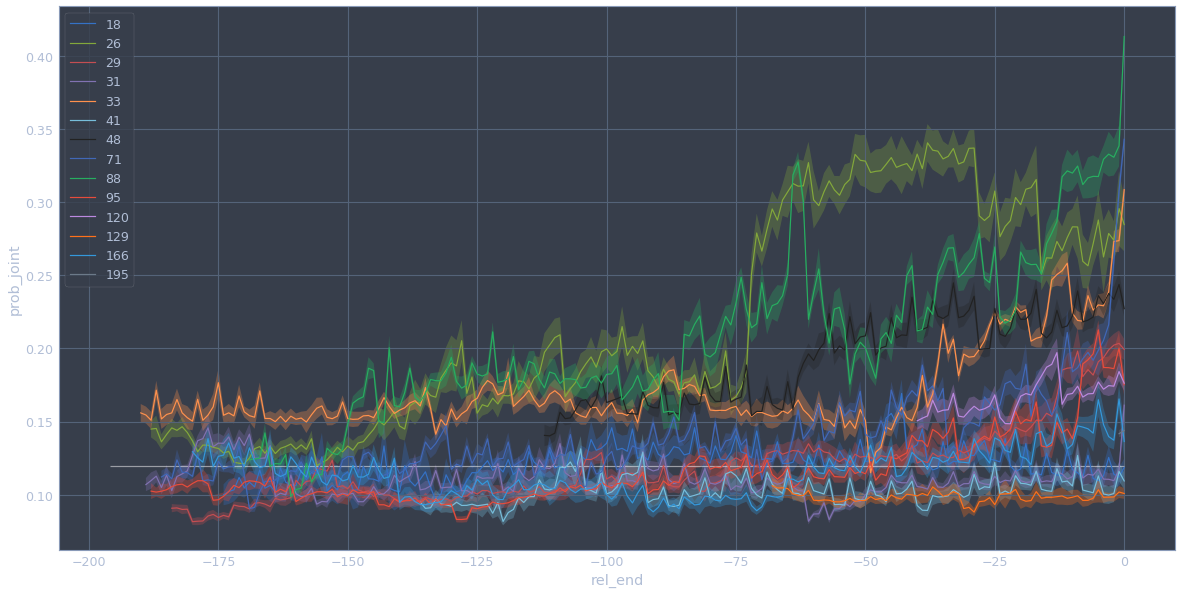

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
for key, group in test_pd[test_pd['patient_inds'] < 200].groupby('patient_inds'):
    group.plot(x='rel_end', y='prob_joint', ax=ax, label=key)
    plt.fill_between(group['rel_end'],
                    group['prob_joint'] - group['prob_joint_std'],
                     group['prob_joint'] + group['prob_joint_std'],
                    alpha=0.3)
ax.hlines(y=0.12, xmin=-196, xmax=0, colors='white', alpha=0.5)
ax.set_ylabel('prob_joint')

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


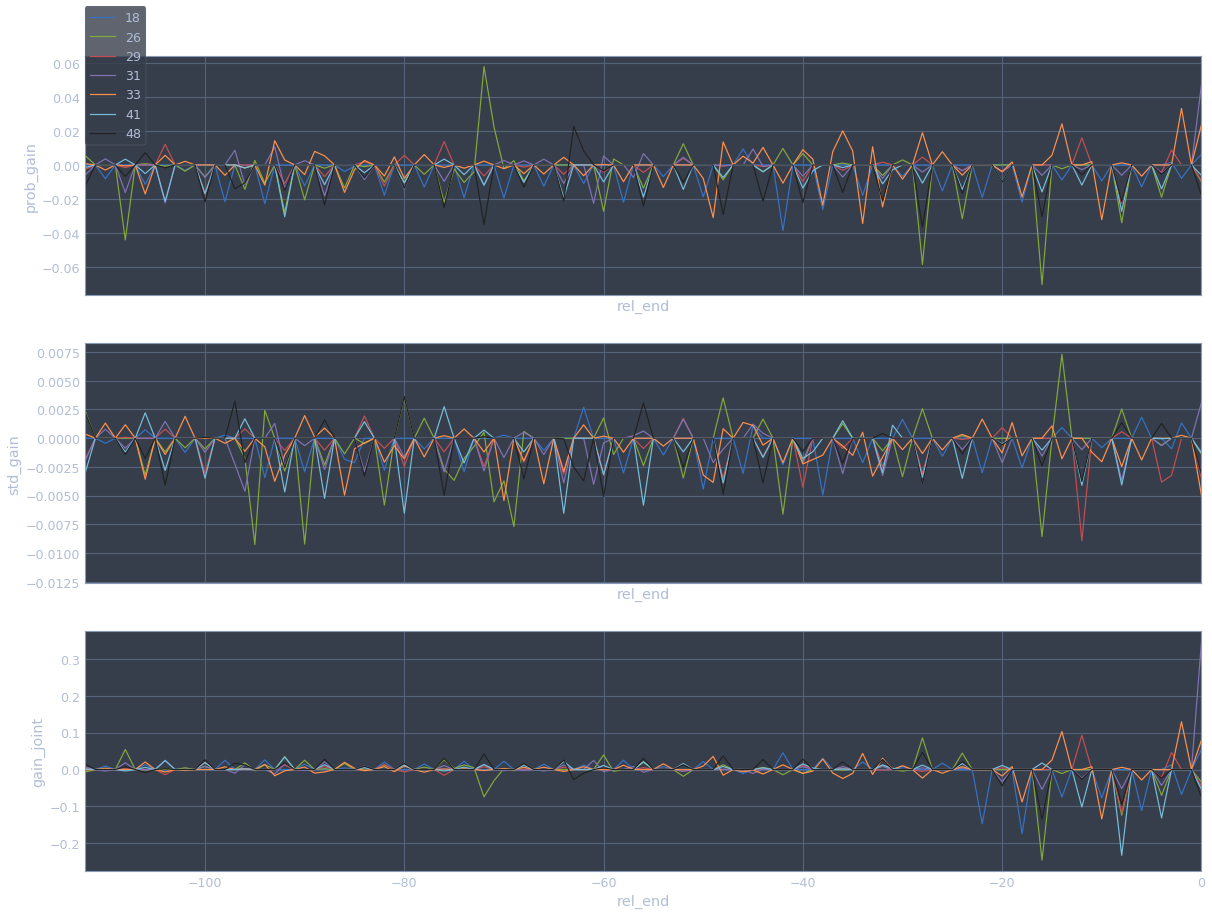

In [66]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

sns.tsplot(test_pd[test_pd['patient_inds'] < 50], time='rel_end', 
           condition='patient_inds', value='prob_gain', ax=ax[0], unit='subject')
sns.tsplot(test_pd[test_pd['patient_inds'] < 50], time='rel_end', 
           condition='patient_inds', value='std_gain', ax=ax[1], unit='subject')
sns.tsplot(test_pd[test_pd['patient_inds'] < 50], time='rel_end', 
           condition='patient_inds', value='gain_joint', ax=ax[2], unit='subject')
# ax[1].legend('off')
ax[0].legend(bbox_to_anchor=(0.06, 0.6))
ax[1].legend_.remove()
ax[2].legend_.remove()

## Error analysis

In [9]:
test_pd['sum_of_gain_per_action'] = test_pd['gain_per_action'].apply(lambda x: x.sum())
ratio = test_pd['gain_joint'].sum() / test_pd['sum_of_gain_per_action'].sum()
test_pd['sum_of_gain_per_action_scaled'] = test_pd['sum_of_gain_per_action'] * ratio

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0.5,1,'x Scaled w/ 0.13. R^2 = 0.803, persons = 0.897')

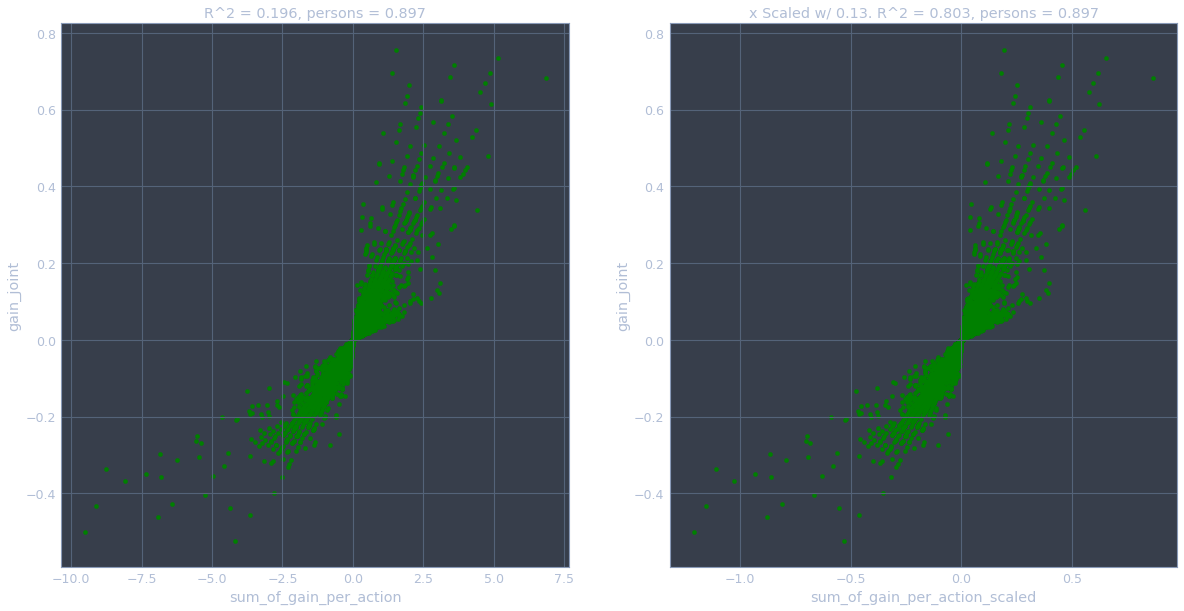

In [10]:
from scipy.stats.stats import pearsonr   

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

r2 = r2_score(test_pd['sum_of_gain_per_action'], test_pd['gain_joint'])
pearson, p = pearsonr(test_pd['sum_of_gain_per_action'], test_pd['gain_joint'])

test_pd.plot(kind='scatter', x='sum_of_gain_per_action', y='gain_joint', colors='green', ax=axes[0])
axes[0].set_title('R^2 = %.3f, persons = %.3f' % (r2, pearson))

r2 = r2_score(test_pd['sum_of_gain_per_action_scaled'], test_pd['gain_joint'])
pearson, p = pearsonr(test_pd['sum_of_gain_per_action_scaled'], test_pd['gain_joint'])

test_pd.plot(kind='scatter', x='sum_of_gain_per_action_scaled', y='gain_joint', colors='green', ax=axes[1])
axes[1].set_title('x Scaled w/ %.2f. R^2 = %.3f, persons = %.3f' % (ratio, r2, pearson))

In [11]:
test_pd['sum_of_prob_gain_per_action'] = test_pd['prob_gain_per_action'].apply(lambda x: x.sum())
prob_ratio = test_pd['prob_gain'].sum() / test_pd['sum_of_prob_gain_per_action'].sum()
test_pd['sum_of_prob_gain_per_action_scaled'] = test_pd['sum_of_prob_gain_per_action'] * prob_ratio

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0.5,1,'x Scaled w/ 0.10. R^2 = 0.757, persons = 0.889')

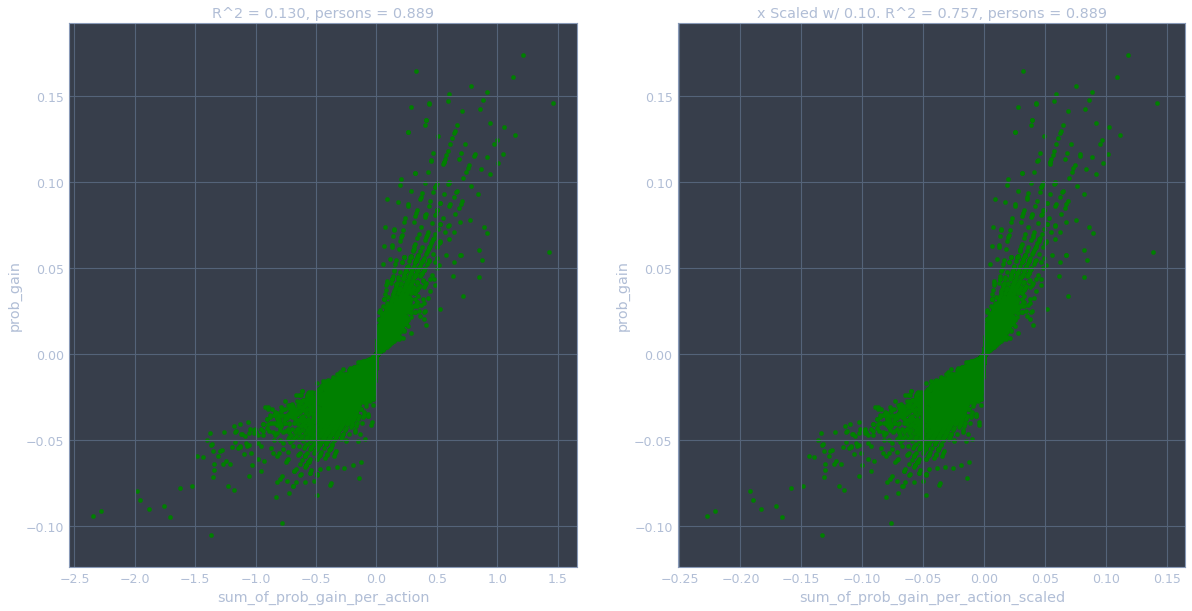

In [12]:
from scipy.stats.stats import pearsonr   

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

r2 = r2_score(test_pd['sum_of_prob_gain_per_action'], test_pd['prob_gain'])
pearson, p = pearsonr(test_pd['sum_of_prob_gain_per_action'], test_pd['prob_gain'])

test_pd.plot(kind='scatter', x='sum_of_prob_gain_per_action', y='prob_gain', colors='green', ax=axes[0])
axes[0].set_title('R^2 = %.3f, persons = %.3f' % (r2, pearson))

r2 = r2_score(test_pd['sum_of_prob_gain_per_action_scaled'], test_pd['prob_gain'])
pearson, p = pearsonr(test_pd['sum_of_prob_gain_per_action_scaled'], test_pd['prob_gain'])

test_pd.plot(kind='scatter', x='sum_of_prob_gain_per_action_scaled', y='prob_gain', colors='green', ax=axes[1])
axes[1].set_title('x Scaled w/ %.2f. R^2 = %.3f, persons = %.3f' % (prob_ratio, r2, pearson))

## Patient trajectory length

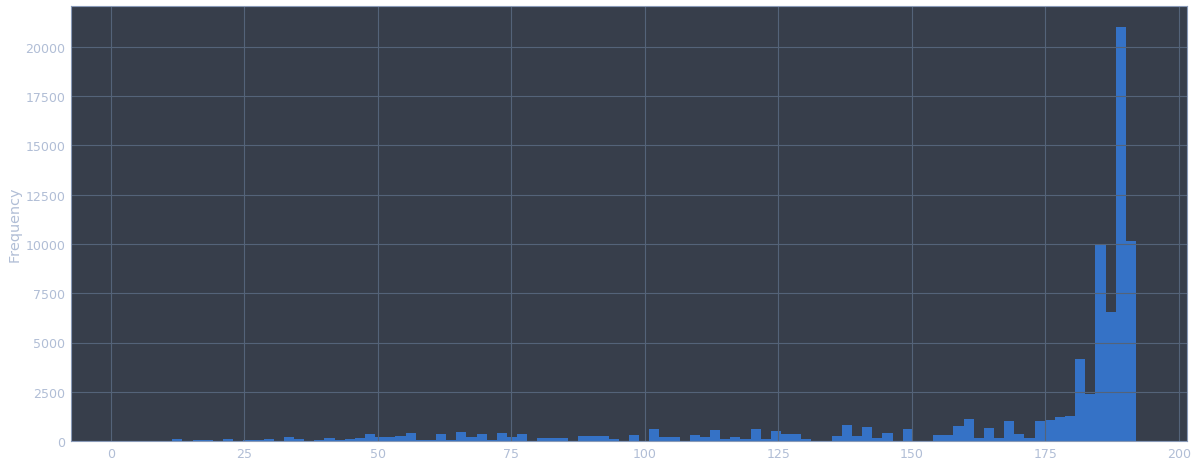

In [13]:
plt.figure(figsize=(20, 8))
test_pd.total_steps.plot.hist(bins=100)

## Early detection

In [14]:
threshold = 0.12

In [15]:
# Calculate early detection
early_detection = test_pd.groupby('patient_inds').apply(
    lambda df: -1. * (df[(df['prob_joint'] > threshold) & (df['rel_end'] >= -24)]['rel_end'].min()))
per_patient_df = pd.DataFrame(early_detection, columns=['early_detection']).reset_index()
per_patient_df.early_detection[per_patient_df.early_detection.isna()] = -1.

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [16]:
'%.1f%% patients of total %d died did not have early detection' % \
    (100 * (per_patient_df['early_detection'] == -1).sum() / per_patient_df.shape[0], 
    per_patient_df.shape[0])

'10.5% patients of total 562 died did not have early detection'

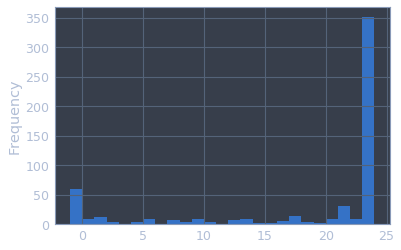

In [17]:
per_patient_df['early_detection'].plot.hist(bins=25)

## False Positive Rate

In [50]:
def fpr_func(x):
    total_pos = (x['prob_joint'] > 0.12).sum()
    return -1. if total_pos == 0 else (((x['labels'] == 0) & (x['prob_joint'] > 0.12)).sum() / total_pos)
per_patient_df['fpr'] = test_pd.groupby('patient_inds').apply(fpr_func).reset_index()[0]

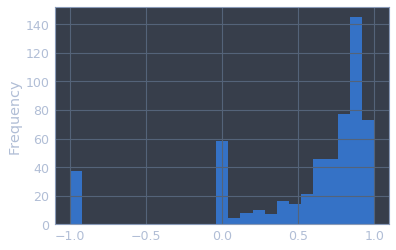

In [51]:
per_patient_df['fpr'].plot.hist(bins=25)

## Sparse Reward

In [30]:
test_pd['ii'] = np.arange(test_pd.shape[0])
per_patient_df['ii'] = np.arange(per_patient_df.shape[0])

In [115]:
# Gamma decay
gamma = 0.999
prob_gain_coef = 1.
action_coef = 0.001
early_detection_coef = 0.05

# TODO: Remove the reward after early_detection time
# Design prob reward as only increasing the probability
test_pd['prob_reward'] = prob_gain_coef * test_pd.ii.apply(
    lambda idx: 0 if test_pd['prob_gain'][idx] < 0 else (gamma ** test_pd['the_steps'][idx]) * test_pd['prob_gain'][idx])
per_patient_df['prob_sum_gain'] = test_pd.groupby('patient_inds')['prob_reward'].apply(
    lambda x: x.sum()).reset_index()['prob_reward']

# Calculate number of actions and the corresponding cost decayed by gamma
test_pd['num_actions'] = test_pd['cur_action'].apply(lambda x: x.sum())
per_patient_df['action_sum_cost'] = action_coef * test_pd.groupby('patient_inds').apply(
    lambda x: ((gamma ** x['the_steps']) * x['num_actions']).sum()).reset_index()[0]
per_patient_df['num_actions'] = test_pd.groupby('patient_inds')['num_actions'].apply(
    lambda x: x.sum()).reset_index()['num_actions']

# Calculate early detection reward decayed by gamma
per_patient_df['total_steps'] = test_pd.groupby('patient_inds')['total_steps'].apply(
    lambda x: x.iloc[0]).reset_index()['total_steps']
per_patient_df['early_step'] = per_patient_df['total_steps'] - 2 - per_patient_df['early_detection']
# If no detection, reward is in the end of trajectory
is_no_detection = per_patient_df['early_detection'] == -1
per_patient_df['early_step'][is_no_detection] = per_patient_df['total_steps'][is_no_detection] - 2

per_patient_df['early_detection_reward'] = per_patient_df.ii.apply(
    lambda idx: early_detection_coef * (gamma ** (per_patient_df['early_step'][idx])) * per_patient_df['early_detection'][idx])

per_patient_df['total_rewards'] = per_patient_df['prob_sum_gain'] + \
    per_patient_df['early_detection_reward'] - per_patient_df['action_sum_cost']

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [116]:
per_patient_df.head()

,patient_inds,early_detection,ii,fpr,prob_sum_gain,action_sum_cost,num_actions,total_steps,early_step,early_detection_reward,total_rewards,threshold,prob_gain_scaled_sum,total_rewards_scaling
0,18,24.0,0,0.934783,0.033990,0.322547,350.0,175,149.0,1.033806,0.745248,0.120406,0.033990,-0.127284
1,26,24.0,1,0.888298,0.154309,0.471735,510.0,189,163.0,1.019426,0.702000,0.119838,0.154309,-0.081559
2,29,24.0,2,0.762500,0.101529,0.384761,419.0,185,159.0,1.023514,0.740282,0.081622,0.101529,-0.090852
3,31,9.0,3,0.928571,0.152256,0.470108,511.0,190,179.0,0.376214,0.058362,0.081903,0.152256,-0.082798
4,33,24.0,4,0.878947,0.303422,0.685454,752.0,191,165.0,1.017388,0.635356,0.115100,0.303422,-0.039305


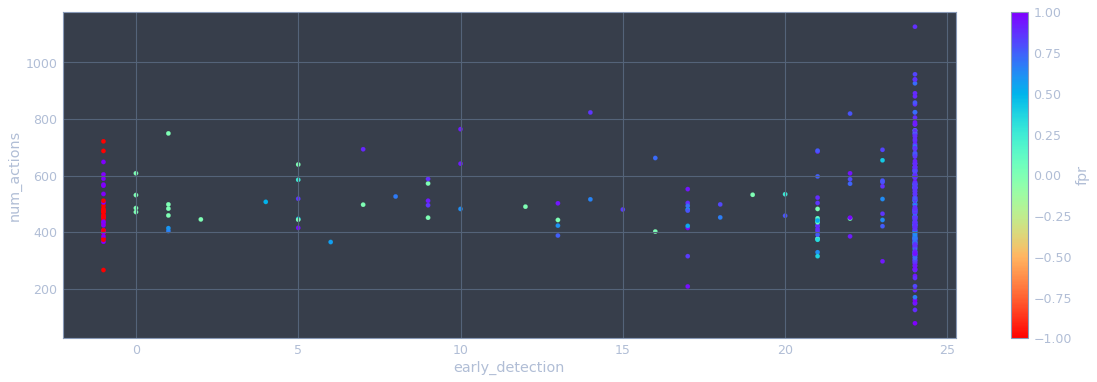

In [117]:
fig, ax = plt.subplots(figsize=(20, 6))
per_patient_df[(per_patient_df['total_steps'] > 150)].plot.scatter(
    x='early_detection', y='num_actions', c='fpr', colormap='rainbow_r', sharex=False, ax=ax)

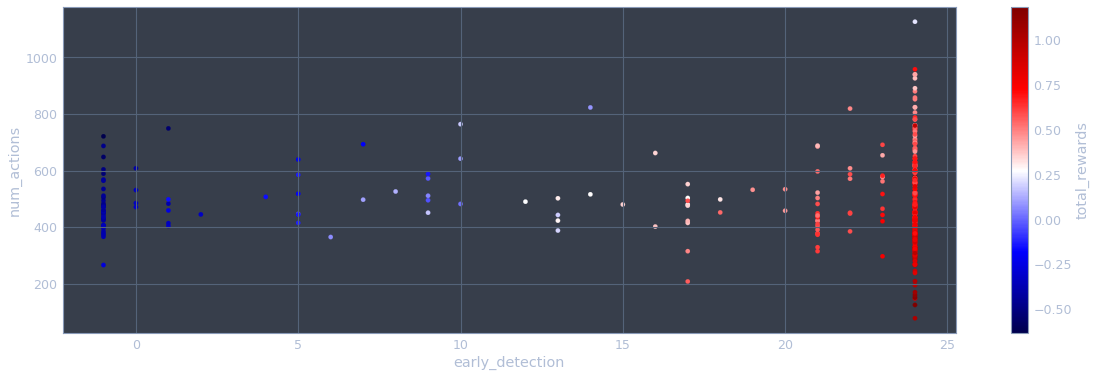

In [118]:
fig, ax = plt.subplots(figsize=(20, 6))
per_patient_df[(per_patient_df['total_steps'] > 150)].plot.scatter(x='early_detection', y='num_actions', c='total_rewards', colormap='seismic',
                           sharex=False, ax=ax)

In [456]:
pd.DataFrame.to_csv(per_patient_df[['patient_inds', 'early_detection']], 'early_detection.csv', index=None)

## Reward Scaling

In [ ]:
# To get scaling. Cache some results
test_pd = test_pd.join(per_patient_df[['patient_inds', 'early_step', 'early_detection']].set_index('patient_inds'), on='patient_inds')

In [149]:
# Gamma decay
gamma = 0.999
prob_gain_coef = 1.
action_coef = 0.001
early_multiplier = 2

# Design prob reward as reward scaling
test_pd['prob_reward'] = prob_gain_coef * test_pd.ii.apply(
    lambda idx: 0 if test_pd['prob_gain'][idx] < 0 else (gamma ** test_pd['the_steps'][idx]) * test_pd['prob_gain'][idx])

per_patient_df['action_sum_cost'] = action_coef * test_pd.groupby('patient_inds').apply(
    lambda x: ((gamma ** x['the_steps']) * x['num_actions']).sum()).reset_index()[0]

def get_scaling(idx):
    p_idx = test_pd['patient_inds'].iloc[idx]
    early_step = test_pd['early_step'].iloc[idx]
    early_detection = test_pd['early_detection'].iloc[idx]
    return early_multiplier * (early_detection + 1) if early_detection > -1 and early_step == test_pd['the_steps'][idx] else 1

test_pd['scaling'] = test_pd.ii.apply(get_scaling)

per_patient_df['prob_gain_scaled_sum'] = test_pd.groupby('patient_inds').apply(
    lambda x: (x['prob_reward'] * x['scaling']).sum()).reset_index()[0]

per_patient_df['total_rewards_scaling'] = per_patient_df['prob_gain_scaled_sum'] - per_patient_df['action_sum_cost']

In [150]:
per_patient_df.head()

,patient_inds,early_detection,ii,fpr,prob_sum_gain,action_sum_cost,num_actions,total_steps,early_step,early_detection_reward,total_rewards,threshold,prob_gain_scaled_sum,total_rewards_scaling
0,18,24.0,0,0.934783,0.033990,0.322547,350.0,175,149.0,1.033806,0.745248,0.120406,0.033990,-0.288557
1,26,24.0,1,0.888298,0.154309,0.471735,510.0,189,163.0,1.019426,0.702000,0.119838,0.154309,-0.317426
2,29,24.0,2,0.762500,0.101529,0.384761,419.0,185,159.0,1.023514,0.740282,0.081622,0.101529,-0.283232
3,31,9.0,3,0.928571,0.152256,0.470108,511.0,190,179.0,0.376214,0.058362,0.081903,0.152256,-0.317852
4,33,24.0,4,0.878947,0.303422,0.685454,752.0,191,165.0,1.017388,0.635356,0.115100,0.303422,-0.382032


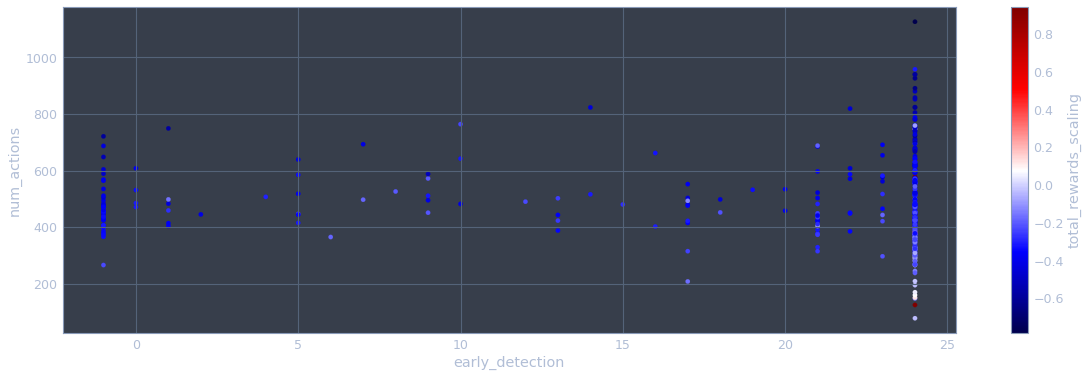

In [151]:
fig, ax = plt.subplots(figsize=(20, 6))
per_patient_df[(per_patient_df['total_steps'] > 150)].plot.scatter(x='early_detection', y='num_actions', c='total_rewards_scaling', colormap='seismic',
               sharex=False, ax=ax)

## Starting prob

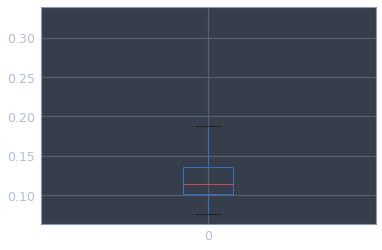

In [173]:
test_pd.groupby('patient_inds').apply(lambda x: x[x['the_steps'] == 0]['prob_joint'].iloc[0]).reset_index().boxplot(column=0)

## Sum of prob joint change v.s. total prob changes

In [292]:
per_patient_df['sum_prob_gain'] = test_pd.groupby('patient_inds').apply(lambda x: x['prob_gain'].sum()).reset_index()[0]
per_patient_df['sum_prob_gain_only_positive'] = test_pd.groupby('patient_inds').apply(lambda x: x['prob_gain'][x['prob_gain'] > 0].sum()).reset_index()[0]
per_patient_df['sum_prob_gain_only_negative'] = per_patient_df['sum_prob_gain'] - per_patient_df['sum_prob_gain_only_positive']
per_patient_df['prob_diff'] = test_pd.groupby('patient_inds')['prob_joint'].apply(lambda x: x.iloc[-1] - x.iloc[0]).reset_index()['prob_joint']

In [293]:
per_patient_df.head()

,patient_inds,early_detection,ii,fpr,prob_sum_gain,action_sum_cost,num_actions,total_steps,early_step,early_detection_reward,total_rewards,threshold,prob_gain_scaled_sum,total_rewards_scaling,sum_prob_gain,prob_diff,sum_prob_gain_only_positive,sum_prob_gain_only_negative
0,18,24.0,0,0.934783,0.033990,0.322547,350.0,175,149.0,1.033806,0.745248,0.120406,0.033990,-0.288557,-0.543987,0.018700,0.037089,-0.581077
1,26,24.0,1,0.888298,0.154309,0.471735,510.0,189,163.0,1.019426,0.702000,0.119838,0.154309,-0.317426,-0.548960,0.139724,0.170569,-0.719529
2,29,24.0,2,0.762500,0.101529,0.384761,419.0,185,159.0,1.023514,0.740282,0.081622,0.101529,-0.283232,-0.070900,0.108503,0.111176,-0.182077
3,31,9.0,3,0.928571,0.152256,0.470108,511.0,190,179.0,0.376214,0.058362,0.081903,0.152256,-0.317852,-0.267848,0.054235,0.168115,-0.435964
4,33,24.0,4,0.878947,0.303422,0.685454,752.0,191,165.0,1.017388,0.635356,0.115100,0.303422,-0.382032,-0.245502,0.152535,0.344628,-0.590130


/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


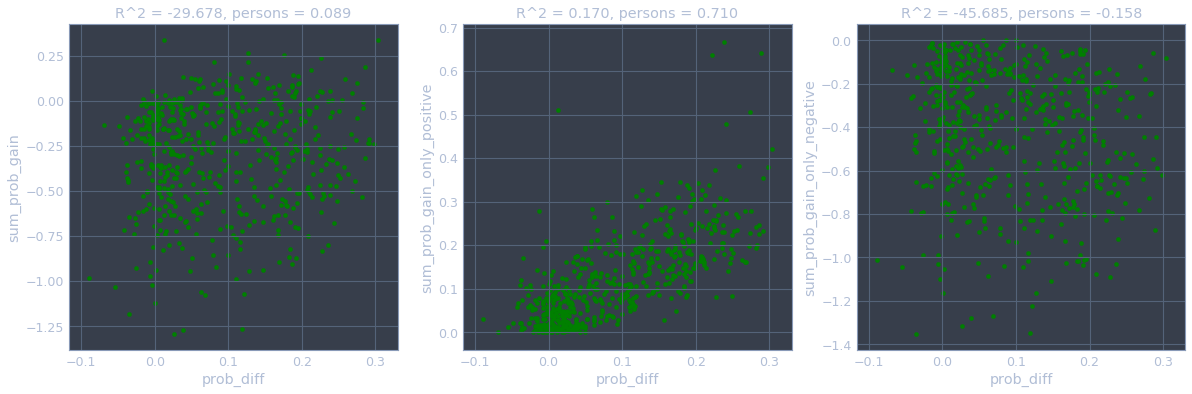

In [295]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

def plot_helper(x_col, y_col, ax):
    r2 = r2_score(per_patient_df[x_col], per_patient_df[y_col])
    pearson, p = pearsonr(per_patient_df[x_col], per_patient_df[y_col])

    per_patient_df.plot(kind='scatter', x=x_col, y=y_col, colors='green', ax=ax)
    ax.set_title('R^2 = %.3f, persons = %.3f' % (r2, pearson))
    
plot_helper('prob_diff', 'sum_prob_gain', ax[0])
plot_helper('prob_diff', 'sum_prob_gain_only_positive', ax[1])
plot_helper('prob_diff', 'sum_prob_gain_only_negative', ax[2])

## Linearly approximate of different time point changes v.s. total changes

In [235]:
test_pd.head(n=3)

,cur_action,cur_prob_joint,cur_prob_joint_std,gain_joint,gain_per_action,labels,next_action,patient_inds,prob_gain_per_action,prob_gain_std_per_action,prob_joint,prob_joint_std,the_steps,total_steps,subject,rel_end,prob_gain,std_gain,sum_of_gain_per_action,sum_of_gain_per_action_scaled,sum_of_prob_gain_per_action,sum_of_prob_gain_per_action_scaled,ii,prob_reward,num_actions,scaling,early_step,early_detection,rel_prob_to_start
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.121604,0.009593,0.02432,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.100005,0.007169,0,175,0,-174,-0.021599,-0.002424,0.194556,0.024643,-0.172792,-0.01677,0,0.0,8.0,1.0,149.0,24.0,0.078406
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.102268,0.008591,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.102268,0.008591,1,175,0,-173,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1,0.0,0.0,1.0,149.0,24.0,0.078406
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.103374,0.007940,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.103374,0.007940,2,175,0,-172,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2,0.0,0.0,1.0,149.0,24.0,0.078406


In [317]:
diff_time_change = test_pd.groupby('patient_inds')['prob_joint'].apply(lambda x: x.iloc[1:].values - x.iloc[:-1].values)
same_time_change = test_pd.groupby('patient_inds').apply(lambda x: x['sum_of_prob_gain_per_action'].values[1:] - x['cur_prob_joint'].values[1:])

In [318]:
diff_time_change = diff_time_change.reset_index()
diff_time_change['sum'] = diff_time_change['prob_joint'].apply(lambda x: x.sum())
diff_time_change['pos_sum'] = diff_time_change['prob_joint'].apply(lambda x: x[x > 0].sum())
diff_time_change['neg_sum'] = diff_time_change['prob_joint'].apply(lambda x: x[x < 0].sum())

same_time_change = same_time_change.reset_index()
same_time_change['sum'] = same_time_change[0].apply(lambda x: x.sum())
same_time_change['pos_sum'] = same_time_change[0].apply(lambda x: x[x > 0].sum())
same_time_change['neg_sum'] = same_time_change[0].apply(lambda x: x[x < 0].sum())

Text(0.5,0,'prob diff')

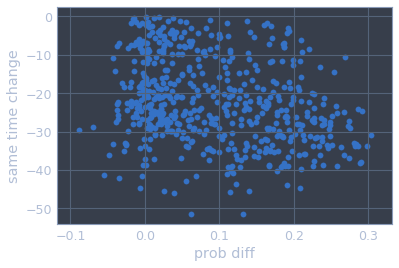

In [321]:
plt.scatter(x=diff_time_change['sum'].values, y=same_time_change['sum'].values)
plt.ylabel('same time change')
plt.xlabel('prob diff')

## Plot negative sum & positive sum to correlate w/ total prob. change. Not much...

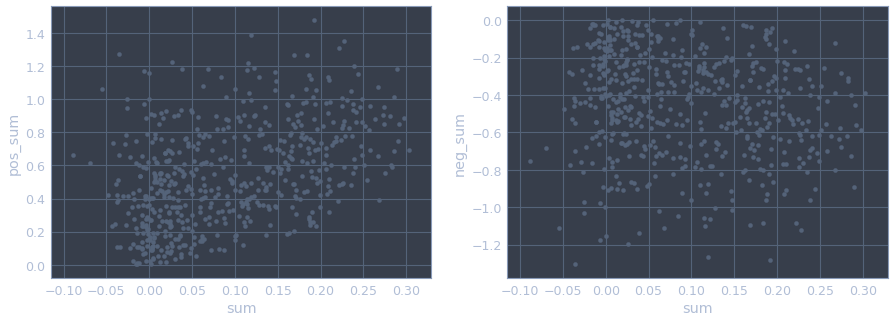

In [323]:
# Compare for difference time positive comparisons
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
diff_time_change.plot.scatter(x='sum', y='pos_sum', ax=axes[0])
diff_time_change.plot.scatter(x='sum', y='neg_sum', ax=axes[1])

### Per-time point scatter plot - pretty corelated 

Text(0,0.5,'diff time change')

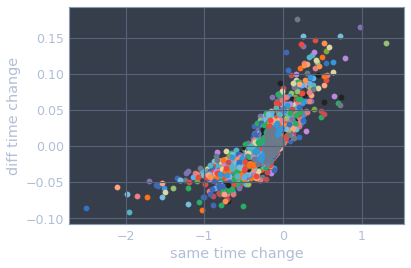

In [315]:
for i in range(300):
    plt.scatter(x=same_time_change[0].iloc[i], y=diff_time_change['prob_joint'].iloc[i])
plt.xlabel('same time change')
plt.ylabel('diff time change')

## Error analysis

In [9]:
test_pd['sum_of_gain_per_action'] = test_pd['gain_per_action'].apply(lambda x: x.sum())
ratio = test_pd['gain_joint'].sum() / test_pd['sum_of_gain_per_action'].sum()
test_pd['sum_of_gain_per_action_scaled'] = test_pd['sum_of_gain_per_action'] * ratio

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0.5,1,'x Scaled w/ 0.13. R^2 = 0.803, persons = 0.897')

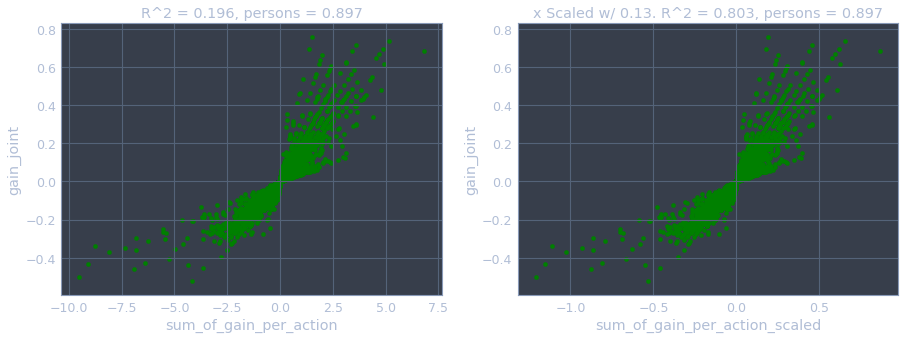

In [339]:
from scipy.stats.stats import pearsonr   

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

r2 = r2_score(test_pd['sum_of_gain_per_action'], test_pd['gain_joint'])
pearson, p = pearsonr(test_pd['sum_of_gain_per_action'], test_pd['gain_joint'])

test_pd.plot(kind='scatter', x='sum_of_gain_per_action', y='gain_joint', colors='green', ax=axes[0])
axes[0].set_title('R^2 = %.3f, persons = %.3f' % (r2, pearson))

r2 = r2_score(test_pd['sum_of_gain_per_action_scaled'], test_pd['gain_joint'])
pearson, p = pearsonr(test_pd['sum_of_gain_per_action_scaled'], test_pd['gain_joint'])

test_pd.plot(kind='scatter', x='sum_of_gain_per_action_scaled', y='gain_joint', colors='green', ax=axes[1])
axes[1].set_title('x Scaled w/ %.2f. R^2 = %.3f, persons = %.3f' % (ratio, r2, pearson))

# axes[1].set_xlim(-0.00001, 0.00001)
# axes[1].set_ylim(-0.00001, 0.00001)

''

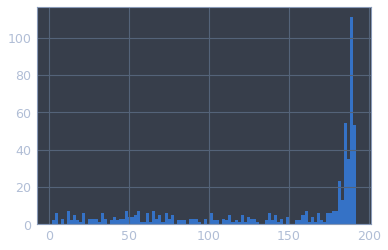

In [351]:
plt.hist(test_pd.groupby('patient_inds')['total_steps'].apply(lambda x: x.iloc[0]).values, bins=100)
''

## Produce final numpy array for test set 
- Remove the step 0 experience => step and total_steps need to adapt :)
- Then only produce 6 hours prediction ahead experience
- Put it back to numpy array

In [441]:
filtered_test_pd = test_pd[(test_pd['total_steps'] >= 48)]
filtered_test_pd

,cur_action,cur_prob_joint,cur_prob_joint_std,gain_joint,gain_per_action,labels,next_action,patient_inds,prob_gain_per_action,prob_gain_std_per_action,prob_joint,prob_joint_std,the_steps,total_steps,subject,rel_end,prob_gain,std_gain,sum_of_gain_per_action,sum_of_gain_per_action_scaled,sum_of_prob_gain_per_action,sum_of_prob_gain_per_action_scaled,ii,prob_reward,num_actions,scaling,early_step,early_detection,rel_prob_to_start
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.121604,0.009593,0.024320,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.100005,0.007169,0,175,0,-174,-0.021599,-0.002424,0.194556,0.024643,-0.172792,-0.016770,0,0.000000,8.0,1.0,149.0,24.0,0.078406
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.102268,0.008591,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.102268,0.008591,1,175,0,-173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.0,1.0,149.0,24.0,0.078406
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.103374,0.007940,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.103374,0.007940,2,175,0,-172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.000000,0.0,1.0,149.0,24.0,0.078406
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.111839,0.012381,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.111839,0.012381,3,175,0,-171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.0,1.0,149.0,24.0,0.078406
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.109590,0.006407,0.005470,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.104705,0.006619,4,175,0,-170,-0.004885,0.000212,0.043758,0.005543,-0.039079,-0.003793,4,0.000000,8.0,1.0,149.0,24.0,0.073521
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.108671,0.007740,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.108671,0.007740,5,175,0,-169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0.000000,0.0,1.0,149.0,24.0,0.073521
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.105411,0.010663,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.105411,0.010663,6,175,0,-168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,0.000000,0.0,1.0,149.0,24.0,0.073521
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.117005,0.014386,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.117005,0.014386,7,175,0,-167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,0.000000,0.0,1.0,149.0,24.0,0.073521
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.115375,0.011051,0.012280,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [442]:
filtered_test_pd['diff_time_prob_gain'] = -10

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [443]:
filtered_test_pd['diff_time_prob_gain'].iloc[1:] = \
    filtered_test_pd['prob_joint'].iloc[1:].values - filtered_test_pd['prob_joint'].iloc[:-1].values

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [444]:
filtered_test_pd = filtered_test_pd[filtered_test_pd['the_steps'] > 0]

In [445]:
filtered_test_pd[['prob_joint', 'diff_time_prob_gain']].head()

,prob_joint,diff_time_prob_gain
1,0.102268,0.002263
2,0.103374,0.001106
3,0.111839,0.008465
4,0.104705,-0.007134
5,0.108671,0.003966


In [446]:
filtered_test_pd.head()

,cur_action,cur_prob_joint,cur_prob_joint_std,gain_joint,gain_per_action,labels,next_action,patient_inds,prob_gain_per_action,prob_gain_std_per_action,prob_joint,prob_joint_std,the_steps,total_steps,subject,rel_end,prob_gain,std_gain,sum_of_gain_per_action,sum_of_gain_per_action_scaled,sum_of_prob_gain_per_action,sum_of_prob_gain_per_action_scaled,ii,prob_reward,num_actions,scaling,early_step,early_detection,rel_prob_to_start,diff_time_prob_gain
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.102268,0.008591,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.102268,0.008591,1,175,0,-173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,1.0,149.0,24.0,0.078406,0.002263
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.103374,0.007940,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.103374,0.007940,2,175,0,-172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.0,0.0,1.0,149.0,24.0,0.078406,0.001106
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.111839,0.012381,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.111839,0.012381,3,175,0,-171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0.0,0.0,1.0,149.0,24.0,0.078406,0.008465
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.109590,0.006407,0.00547,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.104705,0.006619,4,175,0,-170,-0.004885,0.000212,0.043758,0.005543,-0.039079,-0.003793,4,0.0,8.0,1.0,149.0,24.0,0.073521,-0.007134
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.108671,0.007740,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.108671,0.007740,5,175,0,-169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0.0,0.0,1.0,149.0,24.0,0.073521,0.003966


In [447]:
filtered_pat_df = filtered_test_pd.groupby('patient_inds')['prob_joint'].apply(lambda x: x.iloc[len(x)-24] - x.iloc[0]).reset_index()
filtered_pat_df.columns = ['patient_inds', '6hours_prob_diff']
filtered_pat_df['prob_diff'] = filtered_test_pd.groupby('patient_inds')['prob_joint'].apply(lambda x: x.iloc[-1] - x.iloc[0]).values

filtered_pat_df['num_actions'] = filtered_test_pd.groupby('patient_inds')['num_actions'].apply(lambda x: x.sum()).values

In [484]:
# Design rewards
filtered_pat_df['reward'] = filtered_pat_df['6hours_prob_diff'] - 1e-4 * filtered_pat_df['num_actions']

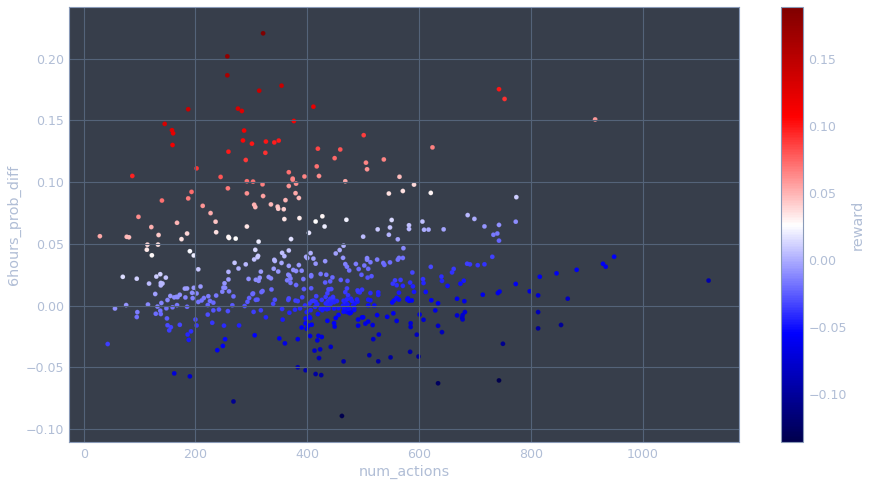

In [485]:
fig, ax = plt.subplots(figsize=(15, 8))
filtered_pat_df.plot.scatter(x='num_actions', y='6hours_prob_diff', c='reward', colormap='seismic', sharex=False, ax=ax)

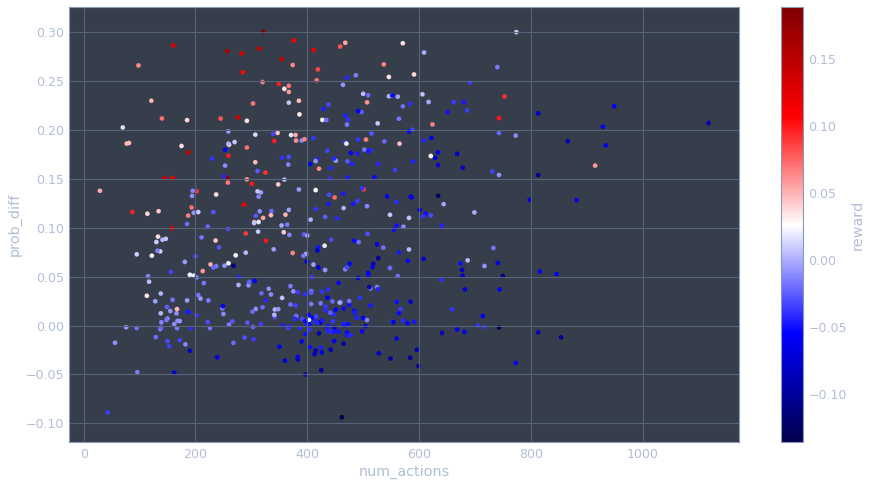

In [450]:
fig, ax = plt.subplots(figsize=(15, 8))
filtered_pat_df.plot.scatter(x='num_actions', y='prob_diff', c='reward', colormap='seismic', sharex=False, ax=ax)

## Preprocess experience to keep 

In [477]:
def get_pd_by_loader(loader):
    test_result = []
    for data_dict in loader:
        processed_dict = {k: data_dict[k][0] for k in [
            'cur_action', 'cur_state', 'next_state',
#             'cur_prob_joint', 'cur_prob_joint_std', 
            'labels', 'next_action',
            'patient_inds', 'prob_gain_per_action', 'prob_joint', 'the_steps', 'total_steps']}
        test_result.append(processed_dict)

    test_pd = pd.DataFrame(test_result)
    return test_pd

def preprocess_pd(loader):
    test_pd = get_pd_by_loader(loader)
    filtered_test_pd = test_pd[(test_pd['total_steps'] >= 48)]
    filtered_test_pd['diff_time_prob_gain'] = -10

    filtered_test_pd['diff_time_prob_gain'].iloc[1:] = \
        filtered_test_pd['prob_joint'].iloc[1:].values - filtered_test_pd['prob_joint'].iloc[:-1].values

    filtered_test_pd = filtered_test_pd[filtered_test_pd['the_steps'] > 0]
    filtered_test_pd['total_steps'] -= 1
    filtered_test_pd['the_steps'] -= 1
    return filtered_test_pd

In [478]:
mimic_cache = MIMIC_cache_discretized_joint_exp_independent_measurement(
    cache_dir='../RL_exp_cache/1012-15mins-48hrs-joint-indep-measurement')
if 'sess' not in locals():
    sess = tf.Session()

train_loader = mimic_cache.gen_train_experience(sess, batch_size=1, shuffle=False)
val_loader = mimic_cache.gen_val_experience(sess, batch_size=1, shuffle=False)
test_loader = mimic_cache.gen_test_experience(sess, batch_size=1, shuffle=False)

In [479]:
# train_df = preprocess_pd(train_loader)
# val_df = preprocess_pd(val_loader)
test_df = preprocess_pd(test_loader)

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [480]:
test_df

,cur_action,cur_state,labels,next_action,next_state,patient_inds,prob_gain_per_action,prob_joint,the_steps,total_steps,diff_time_prob_gain
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0050551, 0.293042, 0.184229, -0.274505, 0....",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00721363, 0.214942, 0.204892, -0.309948, 0...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.102268,0,174,0.002263
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00721363, 0.214942, 0.204892, -0.309948, 0...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0107395, 0.211072, 0.203667, -0.284405, 0....",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.103374,1,174,0.001106
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0107395, 0.211072, 0.203667, -0.284405, 0....",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.000875343, 0.0805188, 0.136899, -0.0618069,...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.111839,2,174,0.008465
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.000875343, 0.0805188, 0.136899, -0.0618069,...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00837107, 0.240519, 0.184334, -0.232273, 0...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.104705,3,174,-0.007134
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00837107, 0.240519, 0.184334, -0.232273, 0...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0124072, 0.274419, 0.169367, -0.162656, 0....",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.108671,4,174,0.003966
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0124072, 0.274419, 0.169367, -0.162656, 0....",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00847125, 0.221138, 0.147022, -0.262156, 0...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.105411,5,174,-0.003259
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00847125, 0.221138, 0.147022, -0.262156, 0...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00685536, 0.113388, 0.141971, 0.103515, 0.2...",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.117005,6,174,0.011593
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00685536, 0.113388, 0.141971, 0.103515, 0.2...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0105364, 0.329035, 0.158117, -0.165588, 0....",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.104500,7,174,-0.012504
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0105364, 0.329035, 0.158117, -0.165588, 0....",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.016252, 0.306872, 0.168605, -0.0840887, 0....",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.106412,8,174,0.001912
10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.016252, 0.306872, 0.168605, -0.0840887, 0....",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0124682, 0.346195, 0.20565, -0.0930199, 0....",18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.101886,9,174,-0.004526


In [481]:
test_df.to_csv('../RL_exp_cache/1012-15mins-48hrs-joint-indep-measurement/test.csv', index=None)

## Ideas: give up. Per patient threshold and fpr

In [74]:
from sklearn.metrics import roc_curve
def find_threshold(x):
    if (x['labels'] == 0).sum() == 0:
        return None
    fprs, tprs, thresholds = roc_curve(x['labels'], x['prob_joint'], drop_intermediate=True)
    for fpr, threshold in zip(fprs, thresholds):
        if fpr > 0.5:
            return threshold

per_patient_df['threshold'] = test_pd.groupby('patient_inds').apply(find_threshold).reset_index()[0]

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:547: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [73]:
per_patient_df.head()

,patient_inds,early_detection,ii,fpr,prob_sum_gain,action_sum_cost,num_actions,total_steps,early_step,early_detection_reward,total_rewards,threshold
0,18,24.0,0,0.934783,0.033990,0.322547,350.0,175,150.0,1.032772,0.744215,0.120406
1,26,24.0,1,0.888298,0.154309,0.471735,510.0,189,164.0,1.018407,0.700981,0.119838
2,29,24.0,2,0.762500,0.101529,0.384761,419.0,185,160.0,1.022491,0.739258,0.081622
3,31,9.0,3,0.928571,0.152256,0.470108,511.0,190,180.0,0.375838,0.057986,0.081903
4,33,24.0,4,0.878947,0.303422,0.685454,752.0,191,166.0,1.016371,0.634339,0.115100


In [ ]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, drop_intermediate=True)
